#   Plots for OMIP-MLD paper 

kernel: CMIP6 2019.10

Note: after the first cell, each figure can be run independently excepted for 7 and 8, and 10 and 11. 


In [1]:
import os
import shutil
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
warnings.filterwarnings('ignore')
inputdir = os.environ['HOME']+'/DATA_PAPER/'

#  Figure 1: observations 

Input file: mld_isas_deboyer_holte_gosm_merc1.nc


In [4]:
#  read obs climatologies interpolated on merc1x1 grid 
fildata = inputdir+'mld_isas_deboyer_holte_gosm_merc1.nc'
dtmp = xr.open_dataset(fildata)
#  roll to have Greenwich meridian in the middle 
dtmp=dtmp.roll({'lon':dtmp.sizes['lon'] // 2},roll_coords=True)
dsdatar=dtmp.assign_coords({'lon':(((dtmp['lon'] + 180) % 360) - 180)}) 
dsdatar

<xarray.Dataset>
Dimensions:            (time: 12, lat: 290, lon: 360, season: 2)
Coordinates:
  * time               (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lon                (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat                (lat) float64 -80.05 -79.71 -79.38 ... 89.05 89.38 89.71
    labsea             (season) object ...
Dimensions without coordinates: season
Data variables: (12/16)
    mld_isas           (time, lat, lon) float64 30.19 26.58 25.07 ... nan nan
    mld_deboyer        (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    mld_da_mean        (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    mld_dt_mean        (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    mld_da_std         (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    mld_dt_std         (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ...                 ...
    mld_da_mean_sea    (season, lat, lon) float64 nan nan nan ... 14.9 14.9 14.9
    mld_dt_mean_sea    (season, lat, lon) float64 nan nan nan ... 14.9 14.9 14.9
    mld_da_std_sea     (season, lat, lon) float64 nan nan nan ... 0.0 0.0 0.0
    mld_dt_std_sea     (season, lat, lon) float64 nan nan nan ... 0.0 0.0 0.0
    mld_var_gosm_sea   (season, lat, lon) float64 nan nan nan ... 48.1 85.77
    mld_mean_gosm_sea  (season, lat, lon) float64 nan nan nan ... 23.95 26.54
Attributes:
    regrid_method:  bilinear

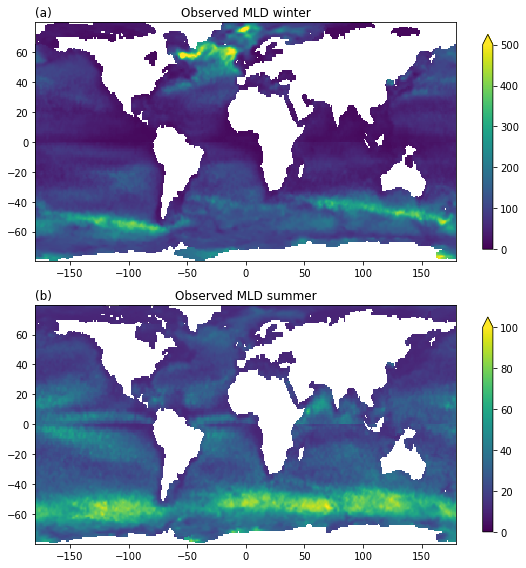

In [5]:
# plot two seasons holte dt and de Boyer
labsea=dsdatar.labsea.values
mmin=0; mmax=[ 500, 100]
# fig,axs=plt.subplots(2,2,figsize=(10,10))
fig = plt.figure(figsize=(8,8))
ilab=['(a)','(b)']
for isea in range (2) : 
#     ax = axs[0,isea]
    plt.subplot(2,1,isea+1)
    tabplt=dsdatar['mld_deboyer_sea'].isel(season=isea).sel(lat=slice(-80,80))
    plt.pcolormesh(tabplt.lon,tabplt.lat,tabplt,vmin=mmin,vmax=mmax[isea])
    plt.title('Observed MLD '+labsea[isea])
    plt.title(ilab[isea],loc='left')
    plt.colorbar(orientation='vertical',shrink=0.9,extend='max')
plt.tight_layout()
plt.show()

#  Figure 2 : analytical profiles

In [7]:
#  create the depth axis and compute index of 50m and 200m depth 
zmax=300
z=np.arange(0,zmax,2)
ktop = np.max(np.argwhere(z<=50))
kmid = np.max(np.argwhere(z<=200))
#
#  define an exponential density profile 
rhosurf=26
deltarho=1.
zscal=zmax/3.
rhoexp=rhosurf+deltarho*(1.-np.exp(-z/zscal))/(1.-np.exp(-zmax/zscal))
#  now define a mixed profile over the top 50m 
rhoav=rhoexp[0:ktop].mean()
rhomix=np.zeros(len(z))
rhomix[0:ktop+1]=rhoav
rhomix[ktop+1::]=rhoexp[ktop+1::]
#  Define a summer profile 
#  ramp over 10 points =20m
kr=10
jk=np.arange(kr)
rhosummer=np.zeros(len(z))
rhosummer[0:ktop+1]=rhoav
rhosummer[ktop+1:ktop+kr+1]=rhoav+(rhoexp[ktop+1+kr]-rhoav)*jk/kr
rhosummer[ktop+1+kr::]=rhoexp[ktop+1+kr::]
#  Define winter profile 
rhowinter=np.zeros(len(z))
rhowinter[0:kmid+1]=rhoexp[kmid]
rhowinter[kmid+1::]=rhoexp[kmid+1::]
#  spring profiel with a small restratification step 
#  rho spring:
rhospring=np.zeros(len(z))
rhospring[:]=rhowinter[:]
# little exponential restrat - delta rho = 0.025
delres= 0.025
kres=25
rhoadd=(rhoexp[kres]-rhoexp)*delres/(rhosurf-rhoexp[kres])
rhospring[0:kres]=rhospring[0:kres]+rhoadd[0:kres]

In [4]:
#  Two useful functions: 
#  function to compute MLD (to mark MLD on the plot) 
#  and another function to facilitate plotting 
#============================================
# function to compute ml depth  from density profile
def mldcalc(delrho,jkref,zdepth,tabprof) :
    refdens = tabprof[jkref]
    tabref = refdens+delrho
    indices=np.argwhere(np.abs(tabprof[jkref:]-refdens) > delrho)
    if (indices.size != 0) :
        iz2 = np.min(indices)-1+jkref   
    #    mld is the interpolated depth 
        mld=( zdepth[iz2]*(tabprof[iz2+1]-tabref) \
                      + zdepth[iz2+1]*(tabref-tabprof[iz2]))  \
                      / (tabprof[iz2+1]-tabprof[iz2])
    else :
        mld[i]=np.nan
    return mld
#====================
#  function for plots to avoid repetition 
def set_stuff(ax,xmin,xmax,*,ileft=True) :
    ax.set_ylim([-300,0])
#     ax.set_yticklabels(fontsize=14)
    ax.set_xlim([xmin,xmax])        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if (ileft==False) :
        ax.spines['left'].set_visible(False)
        ax.get_yaxis().set_ticks([])        
        ax.set_yticklabels([])
    return ax

In [5]:
#  compute the MLDs from the profiles 
#  ref level = 10m, 
kref = np.max(np.argwhere(z<=10))
delrho=[0.01,0.03]
mldsum=np.zeros([2])
mldwin=np.zeros([2])
mldspring=np.zeros([2])
for i in range(2) :
    mldsum[i] = mldcalc(delrho[i],kref,z,rhosummer)
for i in range(2) :
    mldwin[i] = mldcalc(delrho[i],kref,z,rhowinter)
for i in range(2) :
    mldspring[i] = mldcalc(delrho[i],kref,z,rhospring)


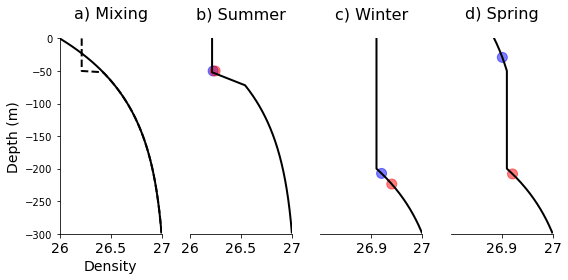

In [8]:
#  plot figure 
mycolors=['b','r']
mysize=100
myalpha=0.5
mylinew=2.
myfont=16
myfont2=14
fig=plt.figure(figsize=(8,4))

ax = fig.add_subplot(1,4,1)
plt.plot(rhomix,-z,'k--',linewidth=mylinew)
plt.plot(rhoexp,-z,'k',linewidth=mylinew)
ax=set_stuff(ax,26,27,ileft=True)
plt.title('a) Mixing',fontsize=myfont,pad=20)
ax.set_xticks([ 26,26.5,27])
ax.set_xticklabels(['26','26.5','27'],fontsize=myfont2)
ax.set_ylabel('Depth (m)',fontsize=myfont2)
ax.set_xlabel('Density',fontsize=myfont2)

ax = fig.add_subplot(1,4,2)
plt.plot(rhosummer,-z,'k',linewidth=mylinew)
plt.scatter(rhosummer[kref]+delrho,-mldsum,c=mycolors,s=mysize,alpha=myalpha)
ax=set_stuff(ax,26,27,ileft=False)
plt.title('b) Summer',fontsize=myfont,pad=20)
ax.set_xticks([ 26,26.5,27])
ax.set_xticklabels(['26','26.5','27'],fontsize=myfont2)

ax = fig.add_subplot(1,4,3)
plt.plot(rhowinter,-z,'k',linewidth=mylinew)
plt.scatter(rhowinter[kref]+delrho,-mldwin,c=mycolors,s=mysize,alpha=myalpha)
ax=set_stuff(ax,26.8,27,ileft=False)
plt.title('c) Winter',fontsize=myfont,pad=20)
ax.set_xticks([ 26.9,27])
ax.set_xticklabels(['26.9','27'],fontsize=myfont2)

ax = fig.add_subplot(1,4,4)
plt.plot(rhospring,-z,'k',linewidth=mylinew)
plt.scatter(rhospring[kref]+delrho,-mldspring,c=mycolors,s=mysize,alpha=myalpha)
ax=set_stuff(ax,26.8,27,ileft=False)
plt.title('d) Spring',fontsize=myfont,pad=20)
ax.set_xticks([ 26.9,27])
ax.set_xticklabels(['26.9','27'],fontsize=myfont2)
plt.tight_layout()
plt.show()

#  Figure 3 
Compare MLD climatology computed with reference depth at 10m and top model level. 
Two contrasting models are chosen. 


original notebook: plot_mld_diff_ref_depth_lowres

Input file: CMCC_CESM_mld_clim_k0_10m.nc

In [6]:
ds_clim_multi=xr.open_dataset(inputdir+'CMCC_CESM_mld_clim_k0_10m.nc')
ds_clim_multi

<xarray.Dataset>
Dimensions:                       (lon: 360, lat: 290, month: 12)
Coordinates:
    member_id                     object ...
  * lon                           (lon) float64 0.5 1.5 2.5 ... 358.5 359.5
  * lat                           (lat) float64 -80.05 -79.71 ... 89.38 89.71
  * month                         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    CMCC-CM2-SR5.omip2_mld03_10m  (month, lat, lon) float64 ...
    CMCC-CM2-SR5.omip2_mld03_k0   (month, lat, lon) float64 ...
    CESM2.omip2_mld03_10m         (month, lat, lon) float32 ...
    CESM2.omip2_mld03_k0          (month, lat, lon) float64 ...

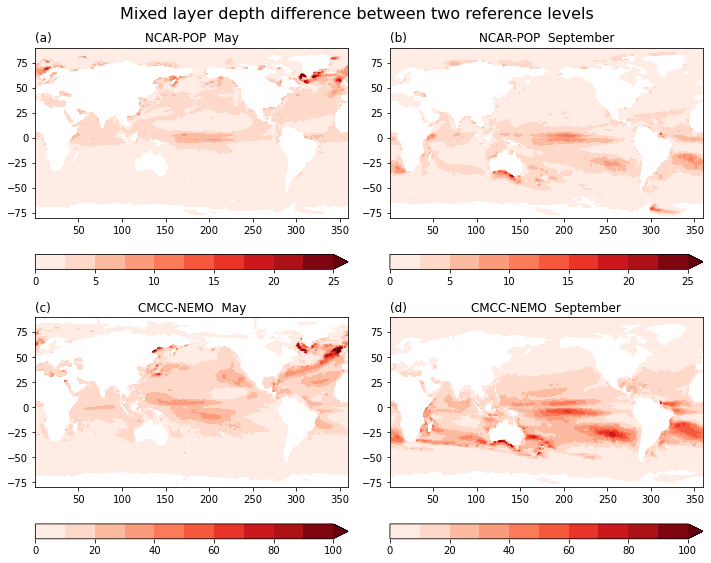

In [8]:
#  plot for paper 
#  mld 10m - mld (ref=first level)
#  even with a nonlinear colorbar, cannot plot both mdoels on the same graph. 
mydiff=' ref(10m)-ref(k0)'
lonplt=ds_clim_multi.lon.values
latplt = ds_clim_multi.lat.values
monthlab = ['May','September']
modlist=[ 'CESM2', 'CMCC-CM2-SR5']
modlab = [ 'NCAR-POP','CMCC-NEMO']
maxmod = [25,100]
mycmap = 'RdBu_r'
mycmap = 'coolwarm'
mycmap='Reds'
fig = plt.figure(figsize=(10,8))
inum=1
ilab=['(a)','(b)','(c)','(d)']
for i,source in enumerate(modlist) :
    varname =source+'.omip2_mld03_10m'
    vark0=source+'.omip2_mld03_k0'
    clev=np.linspace(0,maxmod[i],11)
    for imo,numo in enumerate([ 3 , 8 ]) : 
        plt.subplot(2,2,inum)
        dsplot=(ds_clim_multi[varname]-ds_clim_multi[vark0]).isel(month=numo).values
        plt.contourf(lonplt,latplt,dsplot,levels=clev,cmap=mycmap)
        plt.colorbar(orientation='horizontal')
        plt.title(modlab[i]+ '  '+monthlab[imo])
        plt.title(ilab[inum-1],loc='left')
        inum=inum+1
#  
plt.suptitle('Mixed layer depth difference between two reference levels',fontsize=16)
plt.tight_layout()
plt.show()

#  Figure 4 

Zonal means from observations.

Original notebook: plot_zonal_means

Input file: mld_isas_deboyer_holte_gosm_merc1.nc


In [9]:
#  read obs climatologies 
fildata = inputdir+'mld_isas_deboyer_holte_gosm_merc1.nc'
# fildata = '/glade/work/treguier/REFERENCE_DATA/mld_isas_deboyer_holte_merc1.nc'
dsdata = xr.open_dataset(fildata)
dsdata

<xarray.Dataset>
Dimensions:            (time: 12, lat: 290, lon: 360, season: 2)
Coordinates:
  * time               (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lon                (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat                (lat) float64 -80.05 -79.71 -79.38 ... 89.05 89.38 89.71
    labsea             (season) object ...
Dimensions without coordinates: season
Data variables: (12/16)
    mld_isas           (time, lat, lon) float64 ...
    mld_deboyer        (time, lat, lon) float64 ...
    mld_da_mean        (time, lat, lon) float64 ...
    mld_dt_mean        (time, lat, lon) float64 ...
    mld_da_std         (time, lat, lon) float64 ...
    mld_dt_std         (time, lat, lon) float64 ...
    ...                 ...
    mld_da_mean_sea    (season, lat, lon) float64 ...
    mld_dt_mean_sea    (season, lat, lon) float64 ...
    mld_da_std_sea     (season, lat, lon) float64 ...
    mld_dt_std_sea     (season, lat, lon) float64 ...
    mld_var_gosm_sea   (season, lat, lon) float64 ...
    mld_mean_gosm_sea  (season, lat, lon) float64 ...
Attributes:
    regrid_method:  bilinear

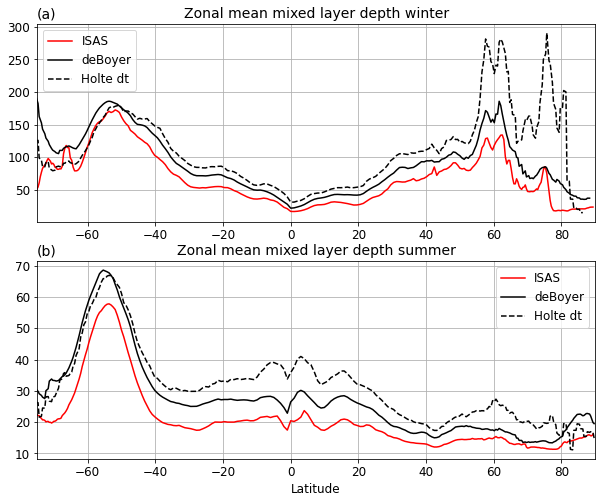

In [18]:
ilab=['(a)','(b)']
varlist= ['mld_isas','mld_deboyer','mld_dt_mean']
varlegend=['ISAS','deBoyer','Holte dt']
curves=['r','k', 'k--',]
myfont=12
plt.figure(figsize=(10,8))
dsdatazon=dsdata.mean(dim='lon')
for isea in range(2) :
    myseason=dsdata.labsea[isea].values
    ax=plt.subplot(2,1,1+isea)
    for i in range(len(varlist)) :
        zmean=dsdatazon[varlist[i]+'_sea'].isel(season=isea)
        plt.plot(dsdata.lat,zmean,curves[i])
    plt.legend(varlegend,fontsize=myfont) 
    plt.title('Zonal mean mixed layer depth '+myseason,fontsize=myfont+2)
    plt.title(ilab[isea],loc='left',fontsize=myfont+2)
    ax.grid(visible=True,axis='both')
    ax.tick_params(axis='both',labelsize=myfont)
    ax.set_xlim([-75,90])
ax.set_xlabel('Latitude',fontsize=myfont)
plt.show()

#  Figure 5 

Maps of monthly mixed layer depth , two regions, two models: Hycom in gulf Stream and IAP-LICOM in Southern Ocean 

Original notebook : plot_daily_monthly_hires_maps_zmean.ipynb

Input files: fsu_hycom_GS_march2018.nc and iap_licom_SO_sept_1998.nc


In [20]:
dicreg = { 'GulfStream':[-70, -40, 25, 45], \
                'SouthernOcean':[-110 ,-67, -65, -45]  }
# Choose Southern Ocean 
chreg='SouthernOcean'
dsreg=xr.open_dataset(inputdir+'iap_licom_SO_sept_1998.nc')
lonplt1=dsreg['longitude']
latplt1=dsreg['latitude']
midlat1 = (dicreg[chreg][2]+dicreg[chreg][3])*0.5
#  factor for plotting (just because I don't use a map projection here)
factor1=np.cos(np.pi*midlat1/180.)
#  select the 15th of the month for the plot 
tabday1=dsreg['IAP-LICOM_daily_sept'].isel(time=14)
tabmon1=dsreg['IAP-LICOM_month_sept']

In [21]:
chreg='GulfStream'
dsreg2=xr.open_dataset(inputdir+'fsu_hycom_GS_march2018.nc')
lonplt2=dsreg2['Longitude']
latplt2=dsreg2['Latitude']
midlat2 = (dicreg[chreg][2]+dicreg[chreg][3])*0.5
#  factor for plotting (just because I don't use a map projection here)
factor2=np.cos(np.pi*midlat1/180.)
#  select the 15th of the month for the plot 
tabday2=dsreg2['FSU-HYCOM_daily_march'].isel(MT=14)
tabmon2=dsreg2['FSU-HYCOM_month_march']

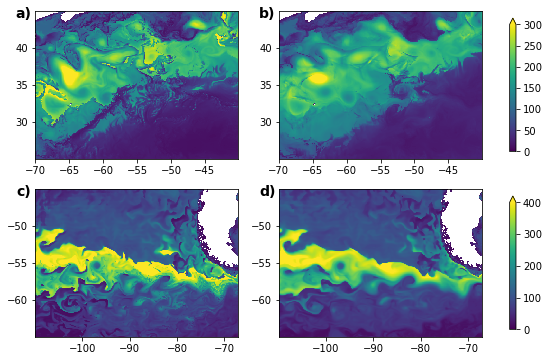

In [24]:
#  fig=plt.figure(figsize=[10,8])
fig, axs = plt.subplots(2, 2,figsize=[10,6])
mydelt=3
myfont=14
#  gulf stream
vmax2 = 300
chreg='GulfStream'
deltax2=dicreg[chreg][0]-mydelt
deltay2=dicreg[chreg][3]-1
mycmap = 'viridis'
# HYCOM gulf Stream
ax = axs[0,0]
pcm = ax.pcolormesh(lonplt2-360,latplt2,tabday2,vmin=0,vmax=vmax2)
ax.text(deltax2,deltay2,'a)',fontsize=myfont,fontweight='bold')
ax = axs[0,1]
ax.text(deltax2,deltay2,'b)',fontsize=myfont,fontweight='bold')
pcm = ax.pcolormesh(lonplt2-360,latplt2,tabmon2,vmin=0,vmax=vmax2)
fig.colorbar(pcm, ax=axs[0, :], shrink=0.9,orientation='vertical',extend='max')

#  SO 
vmax1= 400
chreg='SouthernOcean'
deltax1=dicreg[chreg][0]-4.
deltay1=dicreg[chreg][3]-1.
ax = axs[1,0]
pcm = ax.pcolormesh(lonplt1,latplt1,tabday1,vmin=0,vmax=vmax1)
ax.text(deltax1,deltay1,'c)',fontsize=myfont,fontweight='bold')
ax = axs[1,1]
pcm = ax.pcolormesh(lonplt1,latplt1,tabmon1,vmin=0,vmax=vmax1)
ax.text(deltax1,deltay1,'d)',fontsize=myfont,fontweight='bold')

fig.colorbar(pcm, ax=axs[1, :], shrink=0.9,orientation='vertical',extend='max')
plt.show()


#  Figure 6 

Zonal mean of the difference between daily and monthly MLDs

I work on high resolution models, directly in their native tripolar grid. The data are averaged in zonal bands of width one degree of latitude prior to plotting 

Reference notebook: plot_daily_monthly_hires_maps_zmean.ipynb

input files: mld_licom_zon_daily_monthly_12mo_1998.nc and mld_hycom_zon_daily_monthly_12mo_2018.nc

In [25]:
#  READ the datasets prepared before 
mld_licom_zon=xr.open_dataset(inputdir+'mld_licom_zon_daily_monthly_12mo_1998.nc')
mld_hycom_zon=xr.open_dataset(inputdir+'mld_hycom_zon_daily_monthly_12mo_2018.nc')

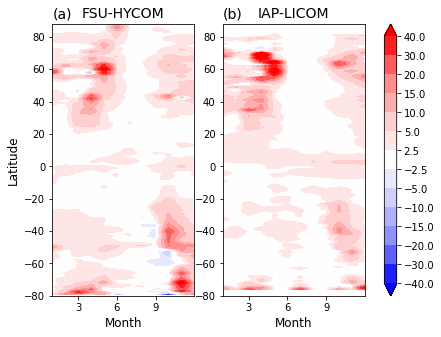

In [26]:
fig, axs = plt.subplots(1,2,figsize=(7,5))
dsdict = { 'hycom':mld_hycom_zon,'licom':mld_licom_zon}
mycont = [-40,-30,  -20, -15, -10, -5.,-2.5,2.5,5.,10, 15,20,30, 40]
#  mycmap='coolwarm'
mycmap='bwr'
ilab=['(a)','(b)']
mytitle=['FSU-HYCOM','IAP-LICOM']
myfont = 12
for i,model in enumerate([ 'hycom','licom']) :
    ds = dsdict[model]
    tabplt=ds['mld_'+model+'_day']-ds['mld_'+model+'_month']
    ax=axs[i]
    pcm=ax.contourf(ds.month,ds.latitude,tabplt,mycont,cmap=mycmap,extend = 'both')
    ax.set_title(mytitle[i],fontsize=myfont+2)
    ax.set_title(ilab[i],loc='left',fontsize=myfont+2)
    ax.set_xlabel('Month',fontsize=myfont)
    ax.set_xticks([3,6,9])
    if ( i==0) :
        ax.set_ylabel('Latitude',fontsize=myfont)
cbar=plt.colorbar(pcm,ax=axs)
cbar.set_ticks(mycont)
#,orientation='horizontal')
plt.show()

#  Figure 7 - winter biases

Maps of model biases at low and high resolution 

Original notebook: model_biases_global_plots. Input files originally in /glade/work/treguier/CLIM1deg/

Input files: mld_isas_deboyer_holte_gosm_merc1.nc, ten_lowres_models_mld03.1989-2018_clim.nc and six_highres_models_mld03.1989-2018_clim.nc

##  7.1 Data preparation for both winter and summer

In [27]:
#  first read lowres and highres models
#  and create a consistent dataset of only seasonal variables 
#  ready for plotting 
dlow=xr.open_dataset(inputdir+'ten_lowres_models_mld03.1989-2018_clim.nc')
dhi=xr.open_dataset(inputdir+'six_highres_models_mld03.1989-2018_clim.nc')
#  Create consistent seasonal dataset 
#  for lowres and high res models 
listmodel=['NCAR-POP','FSU-HYCOM','IAP-LICOM','CMCC-NEMO','AWI-FESOM','ANU-MOM']
#  corresponding variable names ibn lowres clim 
#  
listvarlow=['CESM2.omip2_mld03_10m', 'HYCOMlow.omip2_mld03_10m','FGOALS-f3-L.omip2_mld03_10m', \
            'CMCC-CM2-SR5.omip2_mld03_10m','FESOM.omip2_mld03_10m','ACCESS-OM2.omip2_mld03_10m']
dseason1=xr.Dataset()
for i in range (len(listmodel)) :
    dseason1[listmodel[i]+'_hi']=dhi[listmodel[i]+'_sea']
    dseason1[listmodel[i]+'_low']=dlow[listvarlow[i]+'_sea']

#  for plotting I prefer to start at the dateline 
# I prefer longitudes from -179.5 to 179.5 
#  latitudes are from -89.5
dtmp=dseason1.roll({'lon':dseason1.sizes['lon'] // 2},roll_coords=True)
dseason1=dtmp.assign_coords({'lon':(((dtmp['lon'] + 180) % 360) - 180)}) 
dseason1

<xarray.Dataset>
Dimensions:        (lon: 360, lat: 290, season: 2)
Coordinates:
  * lon            (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat            (lat) float64 -80.05 -79.71 -79.38 ... 89.05 89.38 89.71
    labsea         (season) object ...
    member_id      object ...
Dimensions without coordinates: season
Data variables:
    NCAR-POP_hi    (season, lat, lon) float64 198.8 198.8 198.8 ... 27.09 27.09
    NCAR-POP_low   (season, lat, lon) float32 nan nan nan ... 18.42 18.41 18.41
    FSU-HYCOM_hi   (season, lat, lon) float64 nan nan nan ... 22.55 22.54 22.54
    FSU-HYCOM_low  (season, lat, lon) float64 nan nan nan ... 17.67 17.66 17.66
    IAP-LICOM_hi   (season, lat, lon) float64 nan nan nan ... 11.14 11.15 11.16
    IAP-LICOM_low  (season, lat, lon) float32 nan nan nan ... 15.48 15.48 15.48
    CMCC-NEMO_hi   (season, lat, lon) float64 131.1 206.0 240.4 ... 11.72 11.71
    CMCC-NEMO_low  (season, lat, lon) float64 nan nan nan ... 17.66 17.66 17.66
    AWI-FESOM_hi   (season, lat, lon) float64 nan nan nan ... 17.39 17.4 17.41
    AWI-FESOM_low  (season, lat, lon) float64 nan nan nan ... 20.66 20.66 20.66
    ANU-MOM_hi     (season, lat, lon) float32 nan nan nan ... 13.49 13.49 13.49
    ANU-MOM_low    (season, lat, lon) float64 nan nan nan ... 16.03 16.03 16.03

In [28]:
#  read obs climatologies  and roll longitudes 
fildata = inputdir+'mld_isas_deboyer_holte_gosm_merc1.nc'
dsdata = xr.open_dataset(fildata)
dtmp=dsdata.roll({'lon':dsdata.sizes['lon'] // 2},roll_coords=True)
dsdatar=dtmp.assign_coords({'lon':(((dtmp['lon'] + 180) % 360) - 180)}) 

##  7.2  plot winter biases 

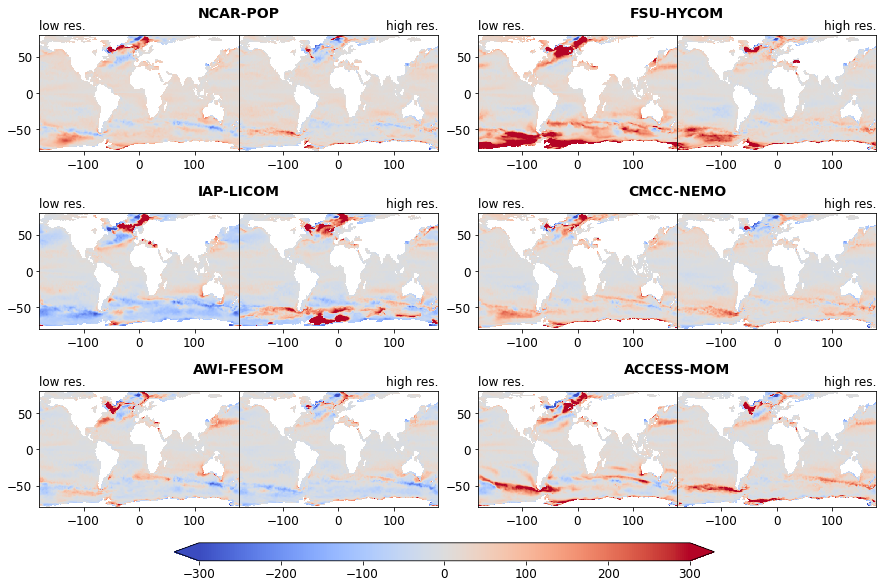

In [29]:
#  plot biases for winter 
#  List of models for plot labels
#  note that for plotting I change ANU-MOM to ACCESS-MOM 
labelmodel=['NCAR-POP','FSU-HYCOM','IAP-LICOM','CMCC-NEMO','AWI-FESOM','ACCESS-MOM']
mycmap='coolwarm'
labsea=dsdata.labsea.values
mmax=[ 300, 30]
myres =[ 'low','hi']
myreslab=[ 'low res.','high res.']
myloc=['left','right']
isea=0
# remark cosntrained layout is like tight layout but experimental. 
# fig = plt.figure(constrained_layout=True)
fig = plt.figure(figsize=(15, 10))
# Create Grid
gs = fig.add_gridspec(nrows=4, ncols=5,hspace=0.7,wspace=0,width_ratios=[1, 1, 0.2, 1,1],\
                     height_ratios=[1,1,1,0.08])
imod=0
for irow in range (3):
    for icol in [ 0,3] :
        for ires in range(2) :
            ax=fig.add_subplot(gs[irow,icol+ires])
            tabplt=(dseason1[listmodel[imod]+'_'+myres[ires]]-dsdatar['mld_deboyer_sea'])\
                          .isel(season=isea).sel(lat=slice(-80,80))
            pcm=ax.pcolormesh(tabplt.lon,tabplt.lat,tabplt,vmin=-mmax[isea],vmax=mmax[isea],cmap=mycmap)
            ax.set_title(myreslab[ires],loc=myloc[ires],fontsize=12)        
            ax.tick_params(axis='both',labelsize=12)
            if (ires == 1) :
                ax.set_yticks([])
            else :
                ax.set_title(labelmodel[imod],fontweight='bold',x=1,y=1.10,fontsize=14)       
        imod=imod+1  
#  when I do this (use cax=), kwargs shrink and aspect do not work for colorbar.
cbar_ax = fig.add_axes([0.25, 0.15, .5, .025]) #left, bottom, width, height
fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal",extend='both')
cbar_ax.tick_params(axis='both',labelsize=12)
plt.show()

# Figure 8 - summer biases

Biases for summer. Need to run 7.1 above before plotting. 

Maps of model biases at low and high resolution 

Original notebook: model_biases_global_plots. Input files originally in /glade/work/treguier/CLIM1deg/

Input files: mld_isas_deboyer_holte_gosm_merc1.nc, ten_lowres_models_mld03.1989-2018_clim.nc and six_highres_models_mld03.1989-2018_clim.nc

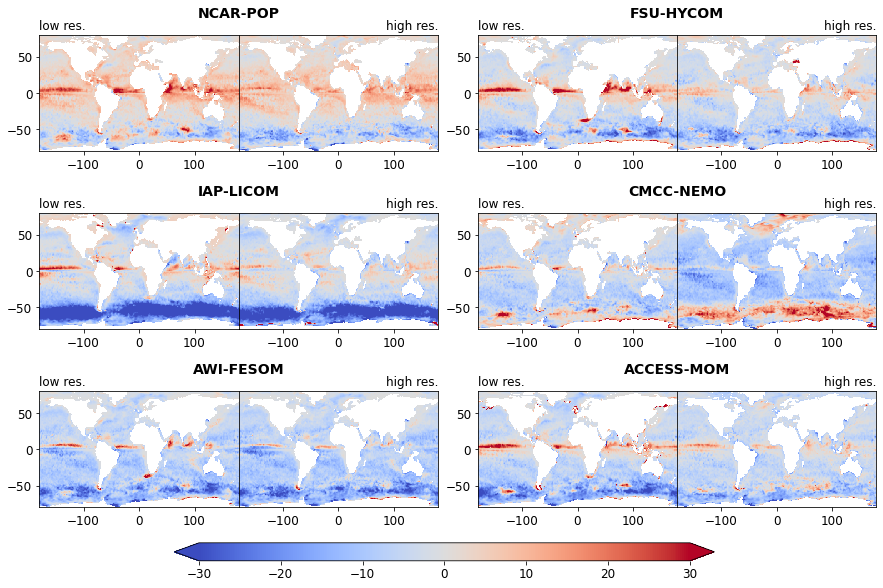

In [34]:
#  plot biases for summer
#  List of models for plot labels
#  note that for plotting I change ANU-MOM to ACCESS-MOM 
labelmodel=['NCAR-POP','FSU-HYCOM','IAP-LICOM','CMCC-NEMO','AWI-FESOM','ACCESS-MOM']
mycmap='coolwarm'
labsea=dsdata.labsea.values
mmax=[ 300, 30]
myres =[ 'low','hi']
myreslab=[ 'low res.','high res.']
myloc=['left','right']
isea=1
# remark cosntrained layout is like tight layout but experimental. 
# fig = plt.figure(constrained_layout=True)
fig = plt.figure(figsize=(15, 10))
# Create Grid
gs = fig.add_gridspec(nrows=4, ncols=5,hspace=0.7,wspace=0,width_ratios=[1, 1, 0.2, 1,1],\
                     height_ratios=[1,1,1,0.08])
imod=0
for irow in range (3):
    for icol in [ 0,3] :
        for ires in range(2) :
            ax=fig.add_subplot(gs[irow,icol+ires])
            tabplt=(dseason1[listmodel[imod]+'_'+myres[ires]]-dsdatar['mld_deboyer_sea'])\
                          .isel(season=isea).sel(lat=slice(-80,80))
            pcm=ax.pcolormesh(tabplt.lon,tabplt.lat,tabplt,vmin=-mmax[isea],vmax=mmax[isea],cmap=mycmap)
            ax.set_title(myreslab[ires],loc=myloc[ires],fontsize=12)        
            ax.tick_params(axis='both',labelsize=12)
            if (ires == 1) :
                ax.set_yticks([])
            else :
                ax.set_title(labelmodel[imod],fontweight='bold',x=1,y=1.10,fontsize=14)       
        imod=imod+1  
#  when I do this (use cax=), kwargs shrink and aspect do not work for colorbar.
cbar_ax = fig.add_axes([0.25, 0.15, .5, .025]) #left, bottom, width, height
fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal",extend='both')
cbar_ax.tick_params(axis='both',labelsize=12)
plt.show()

#  Figure 9 

Original notebook  from plot_zonal_means.ipynb (modified)

Input files: mld_isas_deboyer_holte_gosm_merc1.nc, ten_lowres_models_mld03.1989-2018_clim.nc and six_highres_models_mld03.1989-2018_clim.nc

In [2]:
#  read datasets and compute zonal means 
dlow=xr.open_dataset(inputdir+'ten_lowres_models_mld03.1989-2018_clim.nc')
#  read mixed layer depth 
dhi=xr.open_dataset(inputdir+'six_highres_models_mld03.1989-2018_clim.nc')
fildata = inputdir+'mld_isas_deboyer_holte_gosm_merc1.nc'
dsdata = xr.open_dataset(fildata)
dsdatazon=dsdata.mean(dim='lon')
dshizon=dhi.mean(dim='lon')
dslowzon=dlow.mean(dim='lon')

In [3]:
#  Select variables 
hivar  = ['FSU-HYCOM', 'NCAR-POP', 'IAP-LICOM', 'CMCC-NEMO','AWI-FESOM','ANU-MOM']
lowvar = ['HYCOMlow.omip2_mld03_10m', 'CESM2.omip2_mld03_10m', 'FGOALS-f3-L.omip2_mld03_10m','CMCC-CM2-SR5_mlotst',\
         'FESOM.omip2_mld03_10m','ACCESS-OM2.omip2_mld03_10m']
datavar= ['mld_isas','mld_deboyer']

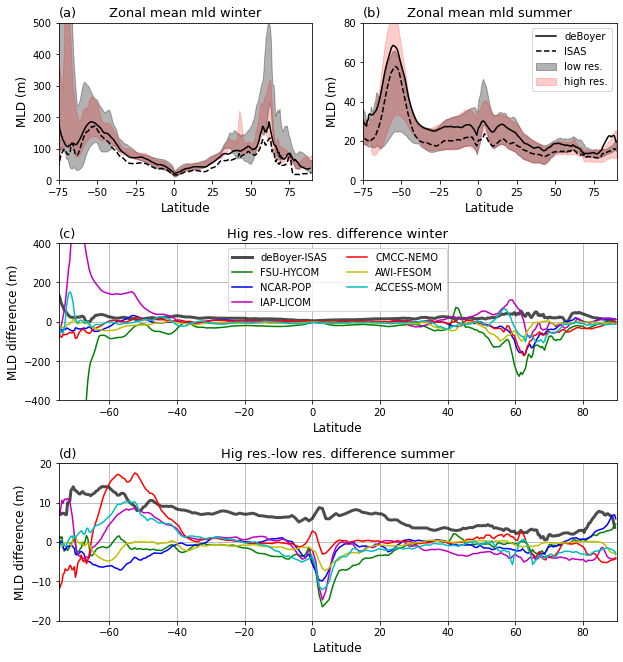

In [36]:
fig=plt.figure(figsize=(10,11))
mylegend1 = ['deBoyer','ISAS','low res.','high res.']
mypanel = ['(a)','(b)','(c)','(d)']
ylimtop=[500,80]
xlim=[-75,90]
myfont = 12
jpj = len(dsdatazon.lat)
# Create Grid
gs = fig.add_gridspec(nrows=3, ncols=2,hspace=0.4,wspace=0.2)
for isea in range(2) : 
    ax=fig.add_subplot(gs[0,isea])
    myseason=str(dsdata.labsea[isea].values)
    dlowmin=4000*np.ones(jpj);dlowmax = np.zeros(jpj)
    for iv in lowvar : 
        dlowmin=np.minimum(dlowmin,dslowzon[iv+'_sea'].isel(season=isea))
        dlowmax=np.maximum(dlowmax,dslowzon[iv+'_sea'].isel(season=isea))
#        alternative: range 
    dhimin=4000*np.ones(jpj);dhimax = np.zeros(jpj)
    for iv in hivar : 
        dhimin=np.minimum(dhimin,dshizon[iv+'_sea'].isel(season=isea))
        dhimax=np.maximum(dhimax,dshizon[iv+'_sea'].isel(season=isea))
    plt.plot(dsdatazon.lat,dsdatazon['mld_deboyer_sea'].isel(season=isea),'k')
    plt.plot(dsdatazon.lat,dsdatazon['mld_isas_sea'].isel(season=isea),'k--')
    plt.fill_between(dsdatazon.lat,dlowmin,dlowmax,color='k',alpha=0.3) 
    plt.fill_between(dsdatazon.lat,dhimin,dhimax,color='r',alpha=0.2) 
    ax.set_ylim(0,ylimtop[isea])
    ax.set_xlim(xlim)    
    ax.set_title('Zonal mean mld '+myseason,fontsize=myfont+1)
    ax.set_title(mypanel[isea],loc='left',fontsize=myfont+1)
    ax.set_xlabel('Latitude',fontsize=myfont)
    ax.set_ylabel('MLD (m)',fontsize=myfont)
    if (isea ==1 ) :
        plt.legend(mylegend1)
mylegend = ['deBoyer-ISAS','FSU-HYCOM', 'NCAR-POP', 'IAP-LICOM', 'CMCC-NEMO','AWI-FESOM','ACCESS-MOM']
curveshi=['g','b','m','r','y','c']
for isea in range(2) :
    myseason=str(dsdata.labsea[isea].values)
    ax=fig.add_subplot(gs[isea+1,:])
    zmean=(dsdatazon[datavar[1]+'_sea']-dsdatazon[datavar[0]+'_sea'])\
           .isel(season=isea)
    plt.plot(dsdata.lat,zmean,'k',linewidth=3,alpha=0.7)
    for i in range(len(hivar)) :
        zmean=(dshizon[hivar[i]+'_sea']- \
        dslowzon[lowvar[i]+'_sea']).isel(season=isea)
        plt.plot(dsdata.lat,zmean,curveshi[i])
    if (isea == 0 ) :
        plt.legend(mylegend,fontsize=10,ncol=2,loc='upper center') 
        ax.set_ylim([-400,400])
    else :
        ax.set_ylim([-20,20])    
    ax.set_title('Hig res.-low res. difference '+myseason,fontsize=myfont+1)
    ax.set_title(mypanel[isea+2],loc='left',fontsize=myfont+1)
    ax.grid(visible=True,axis='both')
    ax.set_xlim([-75,90])    
    ax.set_xlabel('Latitude',fontsize=myfont)
    ax.set_ylabel('MLD difference (m)',fontsize=myfont)
plt.show()

#  figure 10 

MLD seasonal cycle in regions. 

original notebook: define_plot_regions_deep_mld



In [4]:
# Additionnal software
import matplotlib.path as mpath
#  define a dictionary of regions 
regmld = {              'Lab': { 'npoints' : 6,
        'xpoly':[ -59, -56, -45, -45, -55,  -59],
        'ypoly':[  58,  55,  55,  59,  60,   58],
        'name' : 'Labrador Sea'},
                         'Irm':{ 'npoints' : 6,
        'xpoly':[ -45, -40, -35, -39, -45, -45],
        'ypoly':[  55,  55,  60,  64,  59,  55],
        'name' : 'Irminger Sea'},
                          'Eatl':{ 'npoints' : 5,
        'ypoly':[  50,   55,  65.5, 61,  50],
        'xpoly':[  -12.5, -25, -20,  -5, -12.5],
        'name' : 'East subpolar Atlantic'},
                          'Gst':{ 'npoints' : 7,
        'xpoly':[ -70,-55, -47, -44, -50, -72, -70],
        'ypoly':[ 35,  40,  40,  35,  33,  32,  35],
        'name' : 'Gulf Stream'}, 
                          'Grs':{ 'npoints' : 5,
        'xpoly':[ -10,  5,   5, -5 , -10],
        'ypoly':[  72,  72,  80,  80 , 72 ],
        'name' : 'Greenland Sea'},  
                      'Kur':{  'npoints': 5, 
        'xpoly':[ 142, 142, 180, 180, 142],
        'ypoly':[  30, 45,   45,  30,  30],
        'name' : 'Kuroshio'} ,
                     'Spac':{  'npoints': 5,
        'xpoly':[ -152, -68, -68, -152, -152],
        'ypoly':[  -46, -55, -62,  -55,  -46],
        'name' : 'South Pacific'} ,                          
                     'Saus':{  'npoints': 5,
        'xpoly':[ 60,  178, 178,  60, 60],
        'ypoly':[ -37, -50, -57,  -44, -37],
        'name' : 'South Australia'}                           
                           }


In [5]:
def mask_polygon(lonarray,latarray,ipoly,jpoly,ldomesh) :
#
#   function to create a mask from a polygon.
#   all inputs are ndarrays of floats.
#   the polygon is defined by longitudes (ipoly) and latitudes(jpoly)
#   the polygon is assumed to be closed (first point = last point). 
#   lonarray and latarray may be 1D or 2D, depending on the grid of the data to mask.
#   if 1D and ldomesh = true, need to use meshgrid to create lon,lats of all points. 
#   if ldomesh = false, case of AWI (1D arrays of lon,lats of all points). 
#   use matplotlib.path imported as mpath.
#   use numpy as np. 
#   method: create a matplotlib path from the polygon, and use contains_points to make the mask. 
#   return mask: 2D array with dimensions (numlat,numlon), 1 in polygon and np.nan outside. 
#
    if (lonarray.ndim == 1 and ldomesh==True) : 
        lon2D,lat2D = np.meshgrid(lonarray,latarray)
    else :
        lon2D=lonarray ; lat2D=latarray
    lonflt=lon2D.flatten() ; latflt=lat2D.flatten()
    lonlat=np.stack([lonflt,latflt],axis=1) 
    GSpath=mpath.Path(np.stack([ipoly,jpoly],axis=1))
    InGS=GSpath.contains_points(lonlat)
    tmp=np.where(InGS,1,np.nan)
    maskpoly=np.reshape(tmp,lon2D.shape)  
    return(maskpoly)

In [6]:
#  read all low resolution models and roll longitudes
#
dlow=xr.open_dataset(inputdir+'ten_lowres_models_mld03.1989-2018_clim.nc')
dtmp=dlow.roll({'lon':dlow.sizes['lon'] // 2},roll_coords=True)
dlow=dtmp.assign_coords({'lon':(((dtmp['lon'] + 180) % 360) - 180)}) 
listmodel=['NCAR-POP','FSU-HYCOM','IAP-LICOM','CMCC-NEMO','AWI-FESOM','ANU-MOM']

#  read the high resolution models and roll longitudes 
dhi=xr.open_dataset(inputdir+'six_highres_models_mld03.1989-2018_clim.nc')
dtmp=dhi.roll({'lon':dhi.sizes['lon'] // 2},roll_coords=True)
dhi=dtmp.assign_coords({'lon':(((dtmp['lon'] + 180) % 360) - 180)}) 
#  define the variable names for the model pairs
#  first the 6 low resolution models 
listlow=['CESM2.omip2_mld03_10m', 'HYCOMlow.omip2_mld03_10m','FGOALS-f3-L.omip2_mld03_10m', \
            'CMCC-CM2-SR5.omip2_mld03_10m','FESOM.omip2_mld03_10m','ACCESS-OM2.omip2_mld03_10m']
nlow = len(listlow)
modlist=['NCAR-POP low','FSU-HYCOM low','IAP-LICOM low','CMCC-NEMO low','AWI-FESOM low','ACCESS-MOM low']
#  select the 6 high resolution members of the model pairs , monthly data 
listhi = ['NCAR-POP','FSU-HYCOM','IAP-LICOM','CMCC-NEMO','AWI-FESOM','ANU-MOM']
nhi = len(listhi)
modlisthi=['NCAR-POP hi','FSU-HYCOM hi','IAP-LICOM hi','CMCC-NEMO hi','AWI-FESOM hi','ACCESS-MOM hi']

In [7]:
#  Read observation dataset 
#  To have a nice map in this figure I use the deBoyer dataset on its original 1 degree grid
#  I use a mask from CESM2 on the same grid for plotting.
fildata = inputdir+'deboyer_mask_original_grid.nc'
dsdataplot = xr.open_dataset(fildata)
#  I also need the deBoyer dataset on the Mercator grid 
#  to treat the same way as models 
fildata = inputdir+'mld_isas_deboyer_holte_gosm_merc1.nc'
dsdata = xr.open_dataset(fildata)
dtmp=dsdata.roll({'lon':dsdata.sizes['lon'] // 2},roll_coords=True)
dsdata=dtmp.assign_coords({'lon':(((dtmp['lon'] + 180) % 360) - 180)}) 

In [8]:
#  compute masks for all regions
numreg=len(regmld.keys())
mld_av=np.zeros([12,nlow,numreg])
mld_max=np.zeros([12,nlow,numreg])
mldtitle=[]
maskreg = np.zeros([numreg,len(dlow.lat),len(dlow.lon)])            
for inum,namreg in enumerate(sorted(regmld.keys())) :
    xpoly=regmld[namreg]['xpoly']; ypoly=regmld[namreg]['ypoly']
    maskreg[inum,:,:]=mask_polygon(dlow.lon.values,dlow.lat.values,xpoly,ypoly,True)
np.shape(maskreg)

(8, 290, 360)

In [9]:
#  Construct a dataset of lowres models and data in regions 
mldavlo = xr.Dataset()
#  lowres models 
for i,ivar in enumerate(listlow) :
    for inum,namreg in enumerate(sorted(regmld.keys())) :
        dtmp=(dlow[ivar]*maskreg[inum,:,:]).mean(['lon','lat'])
        dtmp=dtmp.expand_dims('region').assign_coords({'region':[namreg]})
        if (inum == 0)  :
            dvar=dtmp
        else :
            dvar = xr.concat([ dvar,dtmp],'region')
    mldavlo[ivar]=dvar
# observations 
ivar = 'mld_deboyer'
for inum,namreg in enumerate(sorted(regmld.keys())) :
    dtmp=(dsdata[ivar]*maskreg[inum,:,:]).mean(['lon','lat'])
    dtmp=dtmp.expand_dims('region').assign_coords({'region':[namreg]})
    if (inum == 0)  :
        dvar=dtmp
    else :
        dvar = xr.concat([ dvar,dtmp],'region')
mldavlo[ivar]=dvar

In [11]:
mldavhi = xr.Dataset()
for i,ivar in enumerate(listhi) :
    for inum,namreg in enumerate(sorted(regmld.keys())) :
        dtmp=(dhi[ivar]*maskreg[inum,:,:]).mean(['lon','lat'])
        dtmp=dtmp.expand_dims('region').assign_coords({'region':[namreg]})
        if (inum == 0)  :
            dvar=dtmp
        else :
            dvar = xr.concat([ dvar,dtmp],'region')
    mldavhi[ivar]=dvar
mldavhi

<xarray.Dataset>
Dimensions:    (month: 12, region: 8)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region     (region) <U4 'Eatl' 'Grs' 'Gst' 'Irm' 'Kur' 'Lab' 'Saus' 'Spac'
Data variables:
    NCAR-POP   (region, month) float64 339.9 390.9 405.5 ... 338.0 158.9 51.04
    FSU-HYCOM  (region, month) float64 379.8 411.2 419.0 ... 333.8 153.7 63.97
    IAP-LICOM  (region, month) float64 546.5 596.8 585.2 ... 274.1 83.9 30.57
    CMCC-NEMO  (region, month) float64 279.4 320.5 337.0 ... 388.8 221.7 84.29
    AWI-FESOM  (region, month) float64 353.1 398.9 417.6 ... 172.4 88.15 44.11
    ANU-MOM    (region, month) float64 372.0 423.8 438.6 ... 439.2 237.4 77.89

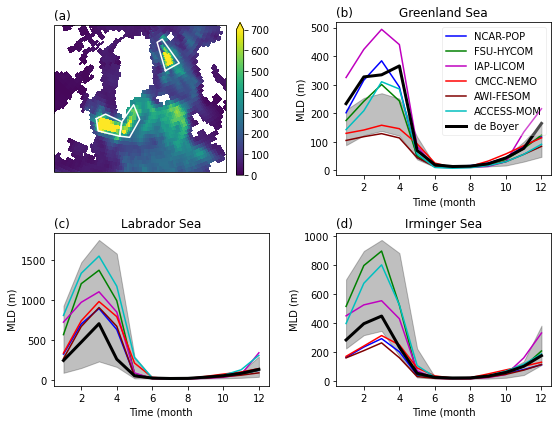

In [13]:
#  plot figure for 3 regions 
reglist = [ 'Grs','Lab','Irm']
#  need to change the name for ANU-MOM
# listhi = ['NCAR-POP','FSU-HYCOM','IAP-LICOM','CMCC-NEMO','AWI-FESOM','ANU-MOM']
modlist=['NCAR-POP','FSU-HYCOM','IAP-LICOM','CMCC-NEMO','AWI-FESOM','ACCESS-MOM']
mycolors=[ 'b','g','m','r','maroon','c']
mypanel=[ '(a)','(b)','(c)','(d)']
fig = plt.figure(figsize=[8,6])
lonplt=dsdataplot.lon
latplt=dsdataplot.lat
dataplt=dsdataplot['mld_deboyer_original'].max('time')*dsdataplot['mask_cesm2']
region = [ -70, 0, 45, 85 ]
lonw = region[0]
lone = region[1]
lats = region[2]
latn = region[3]
central_lon = np.mean([ lonw,lone])
central_lat = np.mean([ lats,latn])
myproj = ccrs.EquidistantConic(central_lon, central_lat, standard_parallels=(lats,latn))
ax = plt.subplot(2,2,1, projection=myproj)
ax.set_extent(region,crs=ccrs.PlateCarree())
plt.pcolormesh(lonplt,latplt,dataplt,vmin=0,vmax=700,transform=ccrs.PlateCarree())
# ax.coastlines(color='w')
for reg in reglist :
    xpoly=regmld[reg]['xpoly']
    ypoly = regmld[reg]['ypoly']
    plt.plot(xpoly,ypoly,'w',transform=ccrs.PlateCarree())
plt.colorbar(extend='max')
mylegend =modlist[0:6]
mylegend.append('de Boyer')
plt.title(mypanel[0],loc='left')
for inum,reg in enumerate(reglist) :
    plt.subplot(2,2,inum+2)
    dtmp=mldavhi.sel(region=reg)
    plt.title(regmld[reg]['name'])
    plt.title(mypanel[1+inum],loc='left')
    for i,ivar in enumerate(listhi) :
        plt.plot(mldavhi.month,dtmp[ivar],color=mycolors[i])
    plt.plot(mldavlo.month,mldavlo['mld_deboyer'].sel(region=reg),'k',linewidth=3)
    if (inum==0) :
        plt.legend(mylegend,loc='upper right',framealpha=0.3)
#   now add low res models with transparency 
    dtmp=mldavlo.sel(region=reg)
    dmin=4000*np.ones(12);dmax = np.zeros(12)
    for i,ivar in enumerate(listlow) :
#        plt.plot(mldavlo.month,dtmp[ivar],alpha=0.3,color=mycolors[i])
        dmin=np.minimum(dmin,dtmp[ivar])
        dmax=np.maximum(dmax,dtmp[ivar])
#        alternative: range 
    plt.fill_between(mldavlo.month,dmin,dmax,color='k',alpha=0.25) 
    plt.xlabel('Time (month')
    plt.ylabel('MLD (m)')
plt.tight_layout()
plt.show()

#  figure 11

Needs to be run after figure 10 

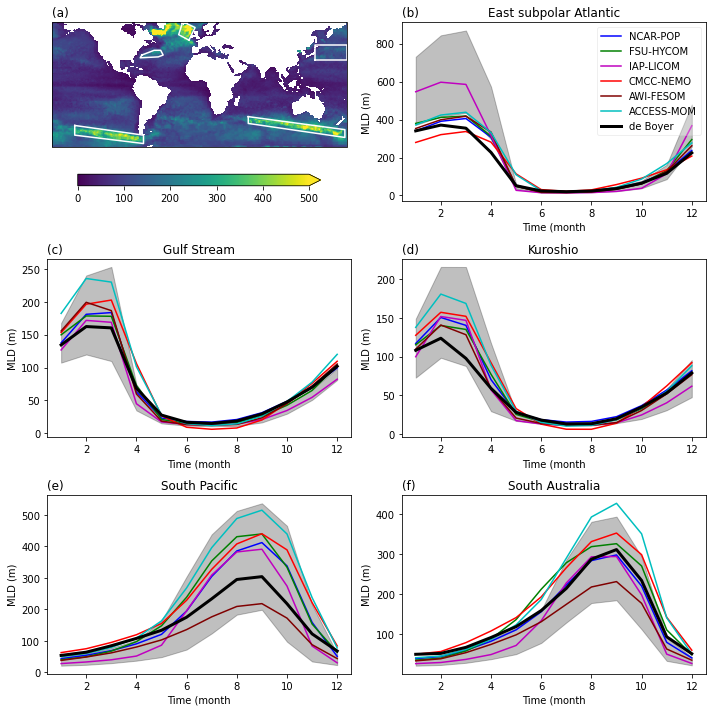

In [14]:
#  Now in 5 regions
mypanel=[ '(a)','(b)','(c)','(d)','(e)','(f)']
mycolors=[ 'b','g','m','r','maroon','c']
reglist = ['Eatl', 'Gst','Kur','Spac','Saus']
fig = plt.figure(figsize=[10,10])
region = [ -180, 180, -65, 65 ]
lonw = region[0]
lone = region[1]
lats = region[2]
latn = region[3]
central_lon = np.mean([ lonw,lone])
central_lat = np.mean([ lats,latn])
# myproj = ccrs.EquidistantConic(central_lon, central_lat, standard_parallels=(lats,latn))
myproj = ccrs.Miller(central_longitude=0.0)
ax = plt.subplot(3,2,1, projection=myproj)
ax.set_extent(region,crs=ccrs.PlateCarree())
plt.pcolormesh(lonplt,latplt,dataplt,vmin=0,vmax=500,transform=ccrs.PlateCarree())
# ax.coastlines(color='w')
plt.title(mypanel[0],loc='left')
for reg in reglist :
    xpoly=regmld[reg]['xpoly']
    ypoly = regmld[reg]['ypoly']
    plt.plot(xpoly,ypoly,'w',transform=ccrs.PlateCarree())
plt.colorbar(orientation='horizontal',extend='max',shrink=0.8)

mylegend =modlist[0:6]
mylegend.append('de Boyer')
for inum,reg in enumerate(reglist) :
    plt.subplot(3,2,inum+2)
    dtmp=mldavhi.sel(region=reg)
    plt.title(regmld[reg]['name'])
    plt.title(mypanel[1+inum],loc='left')
    for i,ivar in enumerate(listhi) :
        plt.plot(mldavhi.month,dtmp[ivar],color=mycolors[i])
    plt.plot(mldavlo.month,mldavlo['mld_deboyer'].sel(region=reg),'k',linewidth=3)
    if (inum==0) :
        plt.legend(mylegend,loc='upper right',framealpha=0.3)
#   now add low res models with transparency 
    dtmp=mldavlo.sel(region=reg)
    dmin=4000*np.ones(12);dmax = np.zeros(12)
    for i,ivar in enumerate(listlow) :
#        plt.plot(mldavlo.month,dtmp[ivar],alpha=0.3,color=mycolors[i])
        dmin=np.minimum(dmin,dtmp[ivar])
        dmax=np.maximum(dmax,dtmp[ivar])
#        alternative: range 
    plt.fill_between(mldavlo.month,dmin,dmax,color='k',alpha=0.25) 
    plt.xlabel('Time (month')
    plt.ylabel('MLD (m)')
plt.tight_layout()
plt.show()
